In [ ]:
!sudo apt-get install cmake build-essential pkg-config libgoogle-perftools-dev

In [1]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install pytube
!pip install moviepy

# Get audio from youtube video

In [3]:
from pytube import YouTube
import hashlib

def encode_url(url):
    return hashlib.sha1(url.encode('utf-8')).hexdigest()

def extract_720p_english_video_and_audio(youtube_video_url, output_path):
    try:
        # Create a YouTube object for the given video URL
        yt = YouTube(youtube_video_url)

        # Get the stream with 720p resolution (video and audio combined)
        stream = yt.streams.filter(res="720p").first()
        if stream is None:
            stream = yt.streams.get_highest_resolution()

        # Get the stream with the English audio
        english_audio_stream = yt.streams.filter(only_audio=True).first()

        if stream and english_audio_stream:
            filename = encode_url(youtube_video_url) + '.mp4'
            # Download the 720p video and the English audio to the specified output path
            video_file = stream.download(output_path, filename=filename, filename_prefix="video_")
            audio_file = english_audio_stream.download(output_path, filename=filename, filename_prefix="audio_")
            return video_file, audio_file
        else:
            return None, None
    except Exception as e:
        raise e


In [4]:
# Example usage:
youtube_video_url = 'https://www.youtube.com/watch?v=gin16OLQdtg'
output_directory = 'output_folder'

video_path, audio_path = extract_720p_english_video_and_audio(youtube_video_url, output_directory)
if video_path and audio_path:
    print(f'720p video downloaded to: {video_path}')
    print(f'English audio downloaded to: {audio_path}')
else:
    print('No 720p video or English audio available for this video.')

720p video downloaded to: /content/output_folder/video_4a850c6d5c353461953ee9b1d92b34a63f7e7a0d.mp4
English audio downloaded to: /content/output_folder/audio_4a850c6d5c353461953ee9b1d92b34a63f7e7a0d.mp4


In [20]:
from IPython.display import Audio

# Use the Audio widget to play the audio
Audio(audio_path)

# Simple STS translation
With Huggingface

## Convert downloaded audio
Convert downloaded audio to the required format for whisper (huggingface)

In [7]:
from moviepy.editor import VideoFileClip
import numpy as np

def extract_audio_signal_and_sampling_rate(file_path):
    try:
        # Load the video file
        video_clip = VideoFileClip(file_path)

        # Extract the audio as a NumPy array
        audio_array = video_clip.audio.to_soundarray()

        # Get the sampling rate
        sampling_rate = audio_array.shape[0] / video_clip.duration

        return audio_array, int(sampling_rate)
    except Exception as e:
        print(e)
        return None, None


def convert_audio_to_mono(audio_array):
    return audio_array.mean(axis=1)

In [8]:
audio_array, sampling_rate = extract_audio_signal_and_sampling_rate(video_path)

if audio_array is not None and sampling_rate is not None:
    print(f'Sampling Rate: {sampling_rate}')
    print(f'Audio Signal Shape: {audio_array.shape}')
else:
    print('Error: Unable to extract audio signal and sampling rate.')

  return stacker(self.iter_chunks(fps=fps, quantize=quantize,



Sampling Rate: 44100
Audio Signal Shape: (5205123, 2)


In [9]:
audio_array = convert_audio_to_mono(audio_array)

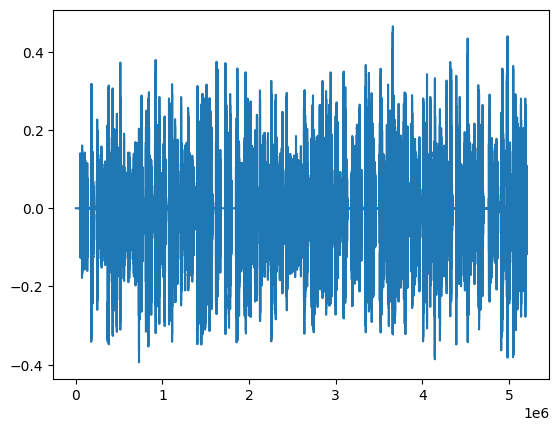

In [10]:
from matplotlib import pyplot as plt
plt.plot(audio_array)
plt.show()

In [11]:
# trim audio to 10 seconds
trimmed_audio_array = audio_array[:sampling_rate * 10]

In [12]:
audio_dict = {"array": trimmed_audio_array,
              "sampling_rate": sampling_rate}

## Apply STT model

In [13]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"This pipeline uses {device=}")

This pipeline uses device='cpu'


In [14]:
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-small", device=device
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
def translate(audio, language="es"):
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "transcribe", "language": language})
    return outputs["text"]

In [16]:
translated_transcription = translate(audio_dict.copy())
translated_transcription

' ¿Qué haces en tu tiempo libre, Ella? Me gusta cocinar. ¡Bien! ¿Qué tipo de comida coces? ¡Masalas internacionales, como en el mundo!'

## Apply TTS model

In [19]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from datasets import load_dataset
import torch
import soundfile as sf

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

inputs = processor(text=translated_transcription, return_tensors="pt")

# load xvector containing speaker's voice characteristics from a dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

sf.write("output_folder/translated_audio_4a850c6d5c353461953ee9b1d92b34a63f7e7a0d.wav", speech.numpy(), samplerate=16000)

Generating validation split: 0 examples [00:00, ? examples/s]

In [21]:
from IPython.display import Audio

# Use the Audio widget to play the audio
translated_audio_path = "/content/output_folder/translated_audio_4a850c6d5c353461953ee9b1d92b34a63f7e7a0d.wav"
Audio(translated_audio_path)